# Check the effect of miRNA levels on PTEN protein abundance 

 miR-25 and miR-93 (from MCM7) expression decrease PTEN protein levels, and result in activation of the Akt pathway
 Could this help explain the tissue dependant effects?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import gseapy as gp
import re
import sys 

import cptac
import cptac.utils as u
import plot_utils as p

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import scipy.stats
import statsmodels.stats.multitest
import operator


def wrap_ttest(df, label_column, comparison_columns=None, alpha=.05, return_all=False, 
               correction_method='bonferroni', mincount=3, pval_return_corrected=True):
    try:
        '''Verify precondition that label column exists and has exactly 2 unique values'''
        label_values = df[label_column].unique()
        if len(label_values) != 2:
            print("Incorrectly Formatted Dataframe! Label column must have exactly 2 unique values.")
            return None
       
        '''Partition dataframe into two sets, one for each of the two unique values from the label column'''
        partition1 = df.loc[df[label_column] == label_values[0]]
        partition2 = df.loc[df[label_column] == label_values[1]]

        '''If no comparison columns specified, use all columns except the specified labed column'''
        if not comparison_columns:
            comparison_columns = list(df.columns)
            comparison_columns.remove(label_column)

        '''Determine the number of real valued columns on which we will do t-tests'''
        number_of_comparisons = len(comparison_columns)

        '''Store comparisons and p-values in two arrays'''
        comparisons = []
        pvals = []
       
        '''Loop through each comparison column, perform the t-test, and record the p-val'''
       
        for column in comparison_columns:
            if len(partition1[column].dropna(axis=0)) <= mincount:
                continue
            elif len(partition2[column].dropna(axis=0)) <= mincount:
                continue
            else:
                stat, pval = scipy.stats.ttest_ind(partition1[column].dropna(axis=0), partition2[column].dropna(axis=0))
                comparisons.append(column)
                pvals.append(pval)
               
        '''Correct for multiple testing to determine if each comparison meets the new cutoff'''
        results = statsmodels.stats.multitest.multipletests(pvals=pvals, alpha=alpha, method=correction_method)
        reject = results[0]

        '''Format results in a pandas dataframe'''
        results_df = pd.DataFrame(columns=['Comparison','P_Value'])

        '''If return all, add all comparisons and p-values to dataframe'''
        if return_all:
            if pval_return_corrected:
                results_df['Comparison'] = comparisons
                results_df['P_Value'] = results[1]

            else:
                results_df['Comparison'] = comparisons
                results_df['P_Value'] = pvals

            '''Else only add significant comparisons'''
        else:
            for i in range(0, len(reject)):
                if reject[i]:
                    if pval_return_corrected:
                        results_df = results_df.append({'Comparison':comparisons[i],'P_Value':results[1][i]}, ignore_index=True)
                    else:
                        results_df = results_df.append({'Comparison':comparisons[i],'P_Value':pvals[i]}, ignore_index=True)


        '''Sort dataframe by ascending p-value'''
        results_df = results_df.sort_values(by='P_Value', ascending=True)
        results_df = results_df.reset_index(drop=True)

        '''If results df is not empty, return it, else return None'''
        if len(results_df) > 0:
            return results_df
        else:
            return None


    except:
        print("Incorrectly Formatted Dataframe!")
        return None



In [180]:
def format_pval_annotation(pval_symbol, x1, x2, line_start = .05, line_height=.05):
    # for manual adjustment to pval annotations
    
    y, h = line_start, line_height
    plt.plot([x1, x1, x2, x2], #draw horizontal line
             [y, y+h, y+h, y], #vertical line
             lw=1.5, color= '.3')
    plt.text((x1+x2)*.5, # half between x coord
             y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")


#  Step 1: Create Data frames with p-values and differences in median

Each cancer needs a data frame containing only samples that have PTEN cnv deletions and PTEN wildtype with trans proteomics. Use wrap_ttest to run many T-tests for all genes in the proteomics data frame. Use get_change_in_medians_df to create the data frame with change in median values. Merge both data frames. 

Load in cancer data sets from cptac. 

In [6]:
g = cptac.Gbm()
en = cptac.Endometrial()
h = cptac.Hnscc()
l = cptac.Luad()
ls = cptac.Lscc()
o = cptac.Ovarian()
col = cptac.Colon()
b = cptac.Brca()

version 3scc v3.2.......                        


In [222]:
# Find miRNA
m = g.get_miRNA()
m = u.reduce_multiindex(m, levels_to_drop = 1)

mb_25 = m.columns.str.contains(r'miR-25')
mir25 = m[m.columns[mb_25]]
mir25.head()

Name,hsa-miR-25-3p,hsa-miR-25-5p
Patient_ID,,
C3L-00104,341.652573,NaN
C3L-00365,343.139007,NaN
C3L-00674,1428.981227,NaN
C3L-00677,890.645621,6.501063
C3L-01040,164.881399,11.371131


# Run t-tests for miR-25 and miR-93

 miR-25 and miR-93 (from MCM7) expression decrease pTEN protein levels, and result in activation of the Akt pathway
 Could this help explain the tissue dependant effects?

In [96]:
def status(row, q1, q3):
    status = 'na'
    for val in row: 
        if pd.isnull(val):
            continue
        val = float(val)
        if val < q1:
            status = 'low'
        elif val < q3:
            status = 'high'
        else:
            status = 'med'
        return status

In [194]:
cancer_objects = {'Gbm':g, 'Hnscc':h, 'Lscc':ls, 'En': en, 'Colon':col} # miRNA not in Brca and Ov # Luad different labels

miRNA_list = ['hsa-miR-25-3p', 'hsa-miR-25-5p', 'hsa-miR-93-3p', 'hsa-miR-93-5p']

dfs = {}
results = {}
all_pval_df = pd.DataFrame()
all_results = pd.DataFrame()

for mirna in miRNA_list:
    all_pval_df = pd.DataFrame()
    for cancer in cancer_objects:
        df = cancer_objects[cancer].get_miRNA()
        if isinstance(df.keys(), pd.core.indexes.multi.MultiIndex):
            df = u.reduce_multiindex(df, levels_to_drop = 1)
        
        # check if miRNA is in dataframe
        if df[df.columns[df.columns.isin([mirna])]].empty == False: 
            mirna_df = df[[mirna]]
        else:
            continue

        # Find the median, quartile 1 and 3
        median = float(mirna_df.median())
        sd = float(mirna_df.std()) # (median + sd) - (med - sd) = 68.2 ???
        #q1 = median - sd
        #q3 = median + sd
        q1 = np.nanpercentile(mirna_df, 25, interpolation = 'nearest') 
        q3 = np.nanpercentile(mirna_df, 75, interpolation = 'nearest') 
        #print('\n', cancer, '\nq1:', q1, '\tmedian:', median, '\tq3:', q3, '\n')

        # add miRNA_status column
        mirna_df['miRNA_status'] = mirna_df.apply(status, args=(q1,q3), axis = 1)


        # Get pten proteomics for tumors
        prot = cancer_objects[cancer].get_proteomics(tissue_type='tumor')
        if isinstance(prot.keys(), pd.core.indexes.multi.MultiIndex):
            prot = u.reduce_multiindex(prot, levels_to_drop = 1)
        pten = prot[['PTEN']]

        # keep miRNA_status and PTEN_proteomics
        both = pten.join(mirna_df[['miRNA_status']])
        high_low = both.loc[both['miRNA_status'] != 'med'].dropna()
        dfs[cancer+'_'+mirna] = high_low
        #print(high_low['miRNA_status'].value_counts(), '\n')
        
        # Get all pvals
        cols = ['PTEN_proteomics']
        pval = wrap_ttest(high_low, 'miRNA_status', return_all = True, correction_method = 'fdr_bh', mincount = 3)
        pval = pval.rename(columns = {'P_Value': cancer+'_P_Value'})
        
        # Get expression differential
        high = high_low[high_low.miRNA_status == "high"]
        low = high_low[high_low.miRNA_status == "low"]
        high_med = high.median()
        low_med = low.median()
        dif = float(high_med) - float(low_med)
        med_df = pd.DataFrame(data={cancer+'_Medians': [dif]})
        
        all_pval_df = all_pval_df.join(pval[[cancer+'_P_Value']], how ='right')
        all_pval_df = all_pval_df.join(med_df, how ='inner')
    all_pval_df['miRNA'] = mirna
    all_results = all_results.append(all_pval_df)
all_results = all_results.set_index('miRNA')

In [195]:
all_results

,Gbm_P_Value,Gbm_Medians,Hnscc_P_Value,Hnscc_Medians,Lscc_P_Value,Lscc_Medians,En_P_Value,En_Medians,Colon_P_Value,Colon_Medians
miRNA,,,,,,,,,,
hsa-miR-25-3p,0.097514,-0.019934,0.977079,-0.057745,0.134563,-0.19320,0.054671,-0.544800,0.604966,0.0747
hsa-miR-25-5p,0.998184,-0.100501,0.819549,0.049240,0.414386,-0.22455,0.042775,-0.638215,0.906450,0.0614
hsa-miR-93-3p,0.401830,-0.018179,0.752492,0.020372,0.155641,-0.49620,0.208408,-0.536450,0.861522,-0.0387
hsa-miR-93-5p,0.166258,-0.021100,0.116336,-0.163366,0.010731,-0.59570,0.007402,-0.656650,0.550937,-0.0280


In [223]:
# Keep only sig pvals
sig = all_results[all_results.columns[::2]].where(all_results < 0.05, np.nan)
sig

,Gbm_P_Value,Hnscc_P_Value,Lscc_P_Value,En_P_Value,Colon_P_Value
miRNA,,,,,
hsa-miR-25-3p,NaN,NaN,NaN,NaN,NaN
hsa-miR-25-5p,NaN,NaN,NaN,0.042775,NaN
hsa-miR-93-3p,NaN,NaN,NaN,NaN,NaN
hsa-miR-93-5p,NaN,NaN,0.010731,0.007402,NaN


# Create boxplot of sig results

In [205]:
# Format sig mirna for boxplot
en_sig_mirna_25 = 'hsa-miR-25-5p'
en_sig_mirna_93 = 'hsa-miR-93-5p'
ls_sig_mirna = 'hsa-miR-93-5p'

ls_df = dfs['Lscc_'+mirna].assign(cancer = 'Lscc_'+ls_sig_mirna[4:])
en_mirna_25_df = dfs['En_'+mirna].assign(cancer = 'Endo_'+en_sig_mirna_25[4:])
en_mirna_93_df = dfs['En_'+mirna].assign(cancer = 'Endo_'+en_sig_mirna_93[4:])
all_sig = ls_df.append(en_mirna_93_df)
all_sig = all_sig.append(en_mirna_25_df)
all_sig

Name,PTEN,miRNA_status,cancer
C3L-00081,-1.3685,low,Lscc_miR-93-5p
C3L-00415,-0.4444,high,Lscc_miR-93-5p
C3L-00568,-0.4809,high,Lscc_miR-93-5p
C3L-00904,0.0797,high,Lscc_miR-93-5p
C3L-00923,0.5749,high,Lscc_miR-93-5p
...,...,...,...
C3N-01219,-0.4340,high,Endo_miR-25-5p
C3N-01267,-0.3720,high,Endo_miR-25-5p
C3N-01537,-0.1640,high,Endo_miR-25-5p
C3N-01802,-0.5720,low,Endo_miR-25-5p


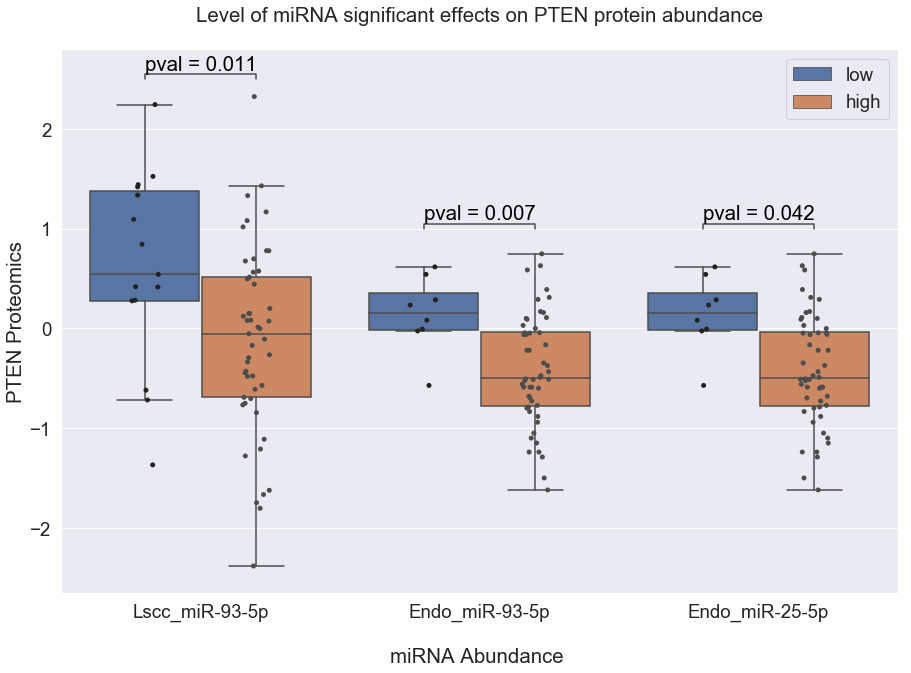

In [219]:
gene = 'PTEN'

plt.rcParams['figure.figsize']=(15,10) #size of plot
sns.set(font_scale = 1.7)

boxplot = sns.boxplot(x='cancer', y=gene, data = all_sig, 
                      hue='miRNA_status', hue_order = ["low", "high"], showfliers = False)    
boxplot.set_title('Level of miRNA significant effects on PTEN protein abundance\n')
boxplot = sns.stripplot(x='cancer', y=gene, data = all_sig, jitter = True, 
                           color = ".3", hue='miRNA_status', hue_order = ["low", "high"],dodge = True)
boxplot.set(xlabel = "\nmiRNA Abundance ", ylabel = 'PTEN Proteomics')

# format legend
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2])

format_pval_annotation('pval = 0.011', -0.2, 0.2, 2.5) 
format_pval_annotation('pval = 0.007', .8, 1.2, 1) 
format_pval_annotation('pval = 0.042', 1.8, 2.2, 1) 

#boxplot.figure.savefig("PTEN_Supplemental_CD5_boxplot.png", dpi = 300)

plt.show()
plt.clf()
plt.close()